# Model Evaluation and Comparison

This notebook is used to evaluate and compare the performance of different models on the test set. We will test the following models:
1. DenseNet
2. DenseNetSE
3. EfficientNet
4. ResNet
5. ViT-Base
6. Traditional machine learning methods

For each model, we will calculate the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score

Finally, we will summarize all results in a table for comparison.

In [ ]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.notebook import tqdm
import gc
import joblib
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import timm
import torch.nn as nn

# Add project root directory to system path
sys.path.append('..')

# Import custom dataset
from dataset import create_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## 1. Load Test Dataset

Use the create_dataloaders function from dataset.py to load the test dataset.

In [ ]:
# Set data path
data_root = '../Aerial_Landscapes'

# Load test dataset
_, _, test_loader, classes = create_dataloaders(
    root_dir=data_root,
    batch_size=32,
    split_ratio=[0.6, 0.2, 0.2],
    augmentation_strategy='default',
    num_workers=0,
    verbose=True
)

print(f"Classes: {classes}")
print(f"Test set size: {len(test_loader.dataset)}")

## 2. Define Evaluation Functions

Create a generic evaluation function to calculate model performance metrics.

In [33]:
def evaluate_model(model, test_loader, device, model_name):
    """Evaluate model performance and return metrics
    
    Parameters:
    model: The model to evaluate
    test_loader: Test data loader
    device: Computation device
    model_name: Model name for saving results
    
    Returns:
    dict: Dictionary containing various metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Save prediction results
    results = {
        'true_labels': all_labels,
        'pred_labels': all_preds
    }
    
    # Create save directory
    os.makedirs('results', exist_ok=True)
    
    # Save results
    np.save(f'results/{model_name}_predictions.npy', results)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.close()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
def evaluate_traditional_model(classifier, test_loader, model_name, feature_method='HOG'):
    """Evaluate traditional machine learning model performance

    Parameters:
    classifier: The classifier model (SVM or KNN)
    test_loader: Test data loader
    model_name: Model name for saving results
    feature_method: Feature extraction method ('HOG' or 'LBP')

    Returns:
    dict: Dictionary containing various metrics
    """
    # Import these here to ensure they are available
    from skimage.feature import hog, local_binary_pattern
    import torchvision.transforms.functional as TF

    # Prepare training data
    train_loader, _, _, _ = create_dataloaders(
        root_dir=data_root,
        batch_size=32,
        split_ratio=[0.6, 0.2, 0.2],
        augmentation_strategy='minimal',
        num_workers=0,
    )

    # Collect training data
    train_images = []
    train_labels = []

    for images, labels in tqdm(train_loader, desc=f"Preparing {model_name} training data"):
        # Convert images to grayscale numpy arrays
        for img, label in zip(images, labels):
            img_pil = TF.to_pil_image(img).convert("L")
            img_np = np.array(img_pil)
            train_images.append(img_np)
            train_labels.append(label.item())

    # Collect test data
    test_images = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc=f"Preparing {model_name} test data"):
        # Convert images to grayscale numpy arrays
        for img, label in zip(images, labels):
            img_pil = TF.to_pil_image(img).convert("L")
            img_np = np.array(img_pil)
            test_images.append(img_np)
            all_labels.append(label.item())

    # Feature extraction
    print(f"Extracting {feature_method} features...")
    X_train = extract_features(train_images, method=feature_method)
    X_test = extract_features(test_images, method=feature_method)
    y_train = np.array(train_labels)
    y_test = np.array(all_labels)

    # Train model
    print(f"Training {model_name}...")
    classifier.fit(X_train, y_train)

    # Save model
    os.makedirs('models', exist_ok=True)
    joblib.dump(classifier, f'models/{model_name.lower()}.joblib')
    print(f"Model saved as models/{model_name.lower()}.joblib")

    # Predict
    print(f"Making predictions with {model_name}...")
    y_pred = classifier.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Save prediction results
    results = {
        'true_labels': y_test,
        'pred_labels': y_pred
    }

    # Create save directory
    os.makedirs('results', exist_ok=True)

    # Save results
    np.save(f'results/{model_name}_predictions.npy', results)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.close()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Define feature extraction functions
def extract_features(images, method='HOG'):
    """Extract HOG or LBP features from images

    Parameters:
    images: List of images
    method: 'HOG' or 'LBP'

    Returns:
    np.array: Array of features
    """
    from skimage.feature import hog, local_binary_pattern

    features = []
    for img in tqdm(images, desc=f"Extracting {method} features"):
        if method == 'HOG':
            feat = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        elif method == 'LBP':
            lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
            feat = hist / np.sum(hist)
        features.append(feat)
    return np.array(features)

## 3. Evaluate Each Model

Now, we will evaluate each model in sequence and release GPU memory after each evaluation.

### 3.1 Evaluate DenseNet Model

In [ ]:
# Load DenseNet model
densenet_model = models.densenet121(pretrained=False)
densenet_model.classifier = torch.nn.Linear(1024, len(classes))

# Load trained weights
densenet_path = 'models/densenet.pth'
if os.path.exists(densenet_path):
    densenet_model.load_state_dict(torch.load(densenet_path))
    print(f"Loaded DenseNet model weights: {densenet_path}")
else:
    print(f"Warning: Could not find DenseNet model weights: {densenet_path}")

# Move model to device
densenet_model = densenet_model.to(device)

# Evaluate model
densenet_results = evaluate_model(densenet_model, test_loader, device, 'DenseNet')
print(f"DenseNet evaluation results: {densenet_results}")

# Release memory
del densenet_model
torch.cuda.empty_cache()
gc.collect()

### 3.2 Evaluate DenseNetSE Model

In [ ]:
# Define SE Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.BatchNorm1d(channel // reduction),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define DenseNet121-SE model
def densenet121_se(num_classes, reduction=8):
    base = models.densenet121(pretrained=True)
    feat = base.features; cls_layer = base.classifier
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.stem = nn.Sequential(*list(feat.children())[:4])
            self.block1, self.trans1 = feat.denseblock1, feat.transition1
            self.block2, self.trans2 = feat.denseblock2, feat.transition2
            self.block3, self.trans3 = feat.denseblock3, feat.transition3
            self.block4 = feat.denseblock4; self.norm5 = feat.norm5
            self.se1 = SEBlock(256, reduction)
            self.se2 = SEBlock(512, reduction)
            self.se3 = SEBlock(1024, reduction)
            self.se4 = SEBlock(1024, reduction)
            self.classifier = nn.Linear(1024, num_classes)
        def forward(self, x):
            x = self.stem(x)
            x = self.block1(x); x = self.se1(x); x = self.trans1(x)
            x = self.block2(x); x = self.se2(x); x = self.trans2(x)
            x = self.block3(x); x = self.se3(x); x = self.trans3(x)
            x = self.block4(x); x = self.se4(x)
            x = self.norm5(x)
            x = nn.functional.adaptive_avg_pool2d(x, (1,1)).view(x.size(0),-1)
            return self.classifier(x)
    return Net()

# Load DenseNetSE model with correct structure
densenetse_model = densenet121_se(num_classes=len(classes))

# Check both possible locations for trained weights
densenetse_path = 'models/densenet_se.pth'
saved_models_path = '../DenseNet/saved_models_se/best_se.pth'

if os.path.exists(densenetse_path):
    densenetse_model.load_state_dict(torch.load(densenetse_path))
    print(f"Loaded DenseNetSE model weights: {densenetse_path}")
elif os.path.exists(saved_models_path):
    densenetse_model.load_state_dict(torch.load(saved_models_path))
    print(f"Loaded DenseNetSE model weights from training directory: {saved_models_path}")
else:
    print(f"Warning: Could not find DenseNetSE model weights")

# Move model to device
densenetse_model = densenetse_model.to(device)

# Evaluate model
densenetse_results = evaluate_model(densenetse_model, test_loader, device, 'DenseNetSE')
print(f"DenseNetSE evaluation results: {densenetse_results}")

# Release memory
del densenetse_model
torch.cuda.empty_cache()
gc.collect()

### 3.3 Evaluate EfficientNet Model

In [ ]:
# Load EfficientNet model
efficientnet_model = models.efficientnet_b0(pretrained=False)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, len(classes))

# Load trained weights
possible_paths = [
    'models/efficientnet.pt',
    'models/efficientnet.pth',
    '../EfficientNet/models/best_model.pt',
    '../EfficientNet/models/efficientnet.pt'
]

weights_loaded = False
for path in possible_paths:
    if os.path.exists(path):
        efficientnet_model.load_state_dict(torch.load(path, map_location=device))
        print(f"Loaded EfficientNet model weights: {path}")
        weights_loaded = True
        break

if not weights_loaded:
    print(f"Warning: Could not find EfficientNet model weights. Checked paths: {possible_paths}")

# Move model to device
efficientnet_model = efficientnet_model.to(device)

# Evaluate model
efficientnet_results = evaluate_model(efficientnet_model, test_loader, device, 'EfficientNet')
print(f"EfficientNet evaluation results: {efficientnet_results}")

# Release memory
del efficientnet_model
torch.cuda.empty_cache()
gc.collect()

### 3.4 Evaluate ResNet Model

In [ ]:
# Load ResNet model
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = torch.nn.Linear(512, len(classes))

# Load trained weights
resnet_path = 'models/resnet.pth'
if os.path.exists(resnet_path):
    resnet_model.load_state_dict(torch.load(resnet_path))
    print(f"Loaded ResNet model weights: {resnet_path}")
else:
    print(f"Warning: Could not find ResNet model weights: {resnet_path}")

# Move model to device
resnet_model = resnet_model.to(device)

# Evaluate model
resnet_results = evaluate_model(resnet_model, test_loader, device, 'ResNet')
print(f"ResNet evaluation results: {resnet_results}")

# Release memory
del resnet_model
torch.cuda.empty_cache()
gc.collect()

### 3.5 Evaluate ViT-Base Model

In [ ]:
# Load ViT-Base model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
in_features = vit_model.head.in_features
vit_model.head = torch.nn.Sequential(
    torch.nn.Linear(in_features, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, len(classes))
)

# Load trained weights
vit_path = 'models/vit_base.pth'
if os.path.exists(vit_path):
    vit_model.load_state_dict(torch.load(vit_path))
    print(f"Loaded ViT-Base model weights: {vit_path}")
else:
    print(f"Warning: Could not find ViT-Base model weights: {vit_path}")

# Move model to device
vit_model = vit_model.to(device)

# Evaluate model
vit_results = evaluate_model(vit_model, test_loader, device, 'ViT-Base')
print(f"ViT-Base evaluation results: {vit_results}")

# Release memory
del vit_model
torch.cuda.empty_cache()
gc.collect()

### 3.6 Evaluate Traditional Machine Learning Models

In [ ]:
# Import required libraries for traditional methods
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import torchvision.transforms.functional as TF

# Create traditional models
print("Creating traditional models...")
traditional_models = {
    'HOG_SVM': SVC(kernel='linear'),
    'HOG_KNN': KNeighborsClassifier(n_neighbors=5),
    'LBP_SVM': SVC(kernel='linear'),
    'LBP_KNN': KNeighborsClassifier(n_neighbors=5)
}

# Evaluate models (including training process)
traditional_results = []

# Evaluate HOG + SVM model
hog_svm_results = evaluate_traditional_model(
    traditional_models['HOG_SVM'], 
    test_loader, 
    'HOG_SVM', 
    feature_method='HOG'
)
traditional_results.append(hog_svm_results)
print(f"HOG + SVM evaluation results: {hog_svm_results}")

# Evaluate HOG + KNN model
hog_knn_results = evaluate_traditional_model(
    traditional_models['HOG_KNN'], 
    test_loader, 
    'HOG_KNN', 
    feature_method='HOG'
)
traditional_results.append(hog_knn_results)
print(f"HOG + KNN evaluation results: {hog_knn_results}")

# Evaluate LBP + SVM model
lbp_svm_results = evaluate_traditional_model(
    traditional_models['LBP_SVM'], 
    test_loader, 
    'LBP_SVM', 
    feature_method='LBP'
)
traditional_results.append(lbp_svm_results)
print(f"LBP + SVM evaluation results: {lbp_svm_results}")

# Evaluate LBP + KNN model
lbp_knn_results = evaluate_traditional_model(
    traditional_models['LBP_KNN'], 
    test_loader, 
    'LBP_KNN', 
    feature_method='LBP'
)
traditional_results.append(lbp_knn_results)
print(f"LBP + KNN evaluation results: {lbp_knn_results}")

# Release memory
gc.collect()

## 4. Summarize Results

Compile all model evaluation results into a table and visualize the comparison.

Model evaluation results summary:


,accuracy,precision,recall,f1_score
model_name,,,,
DenseNet,0.952500,0.954026,0.952500,0.952321
DenseNetSE,0.972083,0.972605,0.972083,0.972052
EfficientNet,0.961250,0.962298,0.961250,0.961180
ResNet,0.952500,0.954130,0.952500,0.952641
ViT-Base,0.962917,0.964592,0.962917,0.963098
HOG_SVM,0.309583,0.304223,0.309583,0.303309
HOG_KNN,0.116250,0.386517,0.116250,0.079364
LBP_SVM,0.182500,0.242422,0.182500,0.130277
LBP_KNN,0.373750,0.385152,0.373750,0.372164


<Figure size 1400x1000 with 0 Axes>

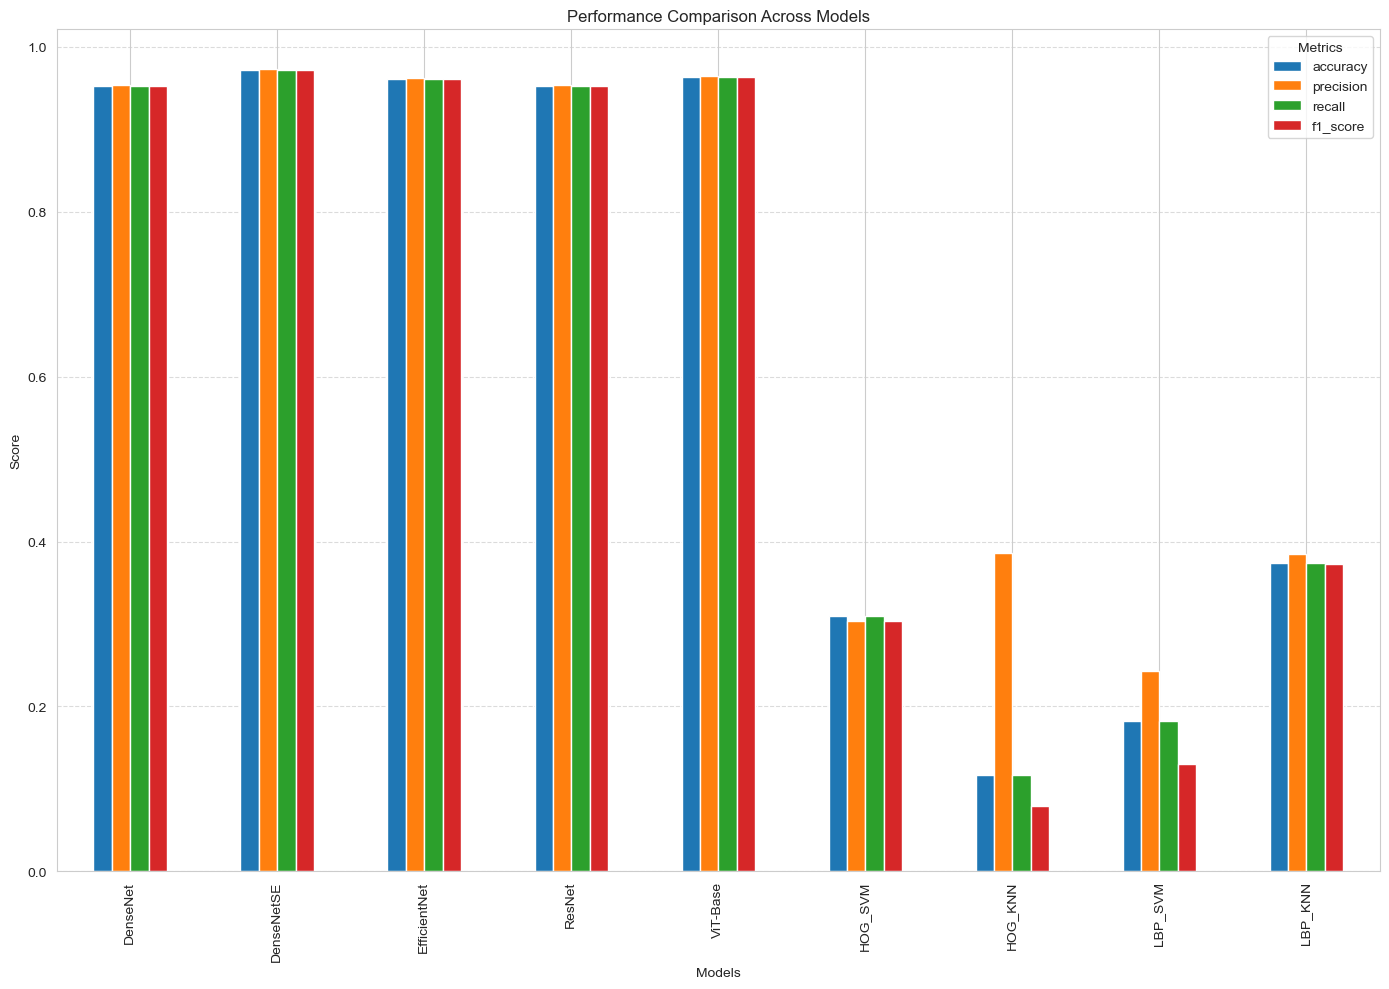

In [35]:
# Summarize all results
all_results = [
    densenet_results,
    densenetse_results,
    efficientnet_results,
    resnet_results,
    vit_results,
] + traditional_results  # Add all traditional model results

# Create DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('model_name')

# Display results table
print("Model evaluation results summary:")
display(results_df)

# Save results to CSV file
results_df.to_csv('results/model_comparison.csv')

# Visualize comparison
plt.figure(figsize=(14, 10))
results_df.plot(kind='bar', figsize=(14, 10))
plt.title('Performance Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/model_comparison.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

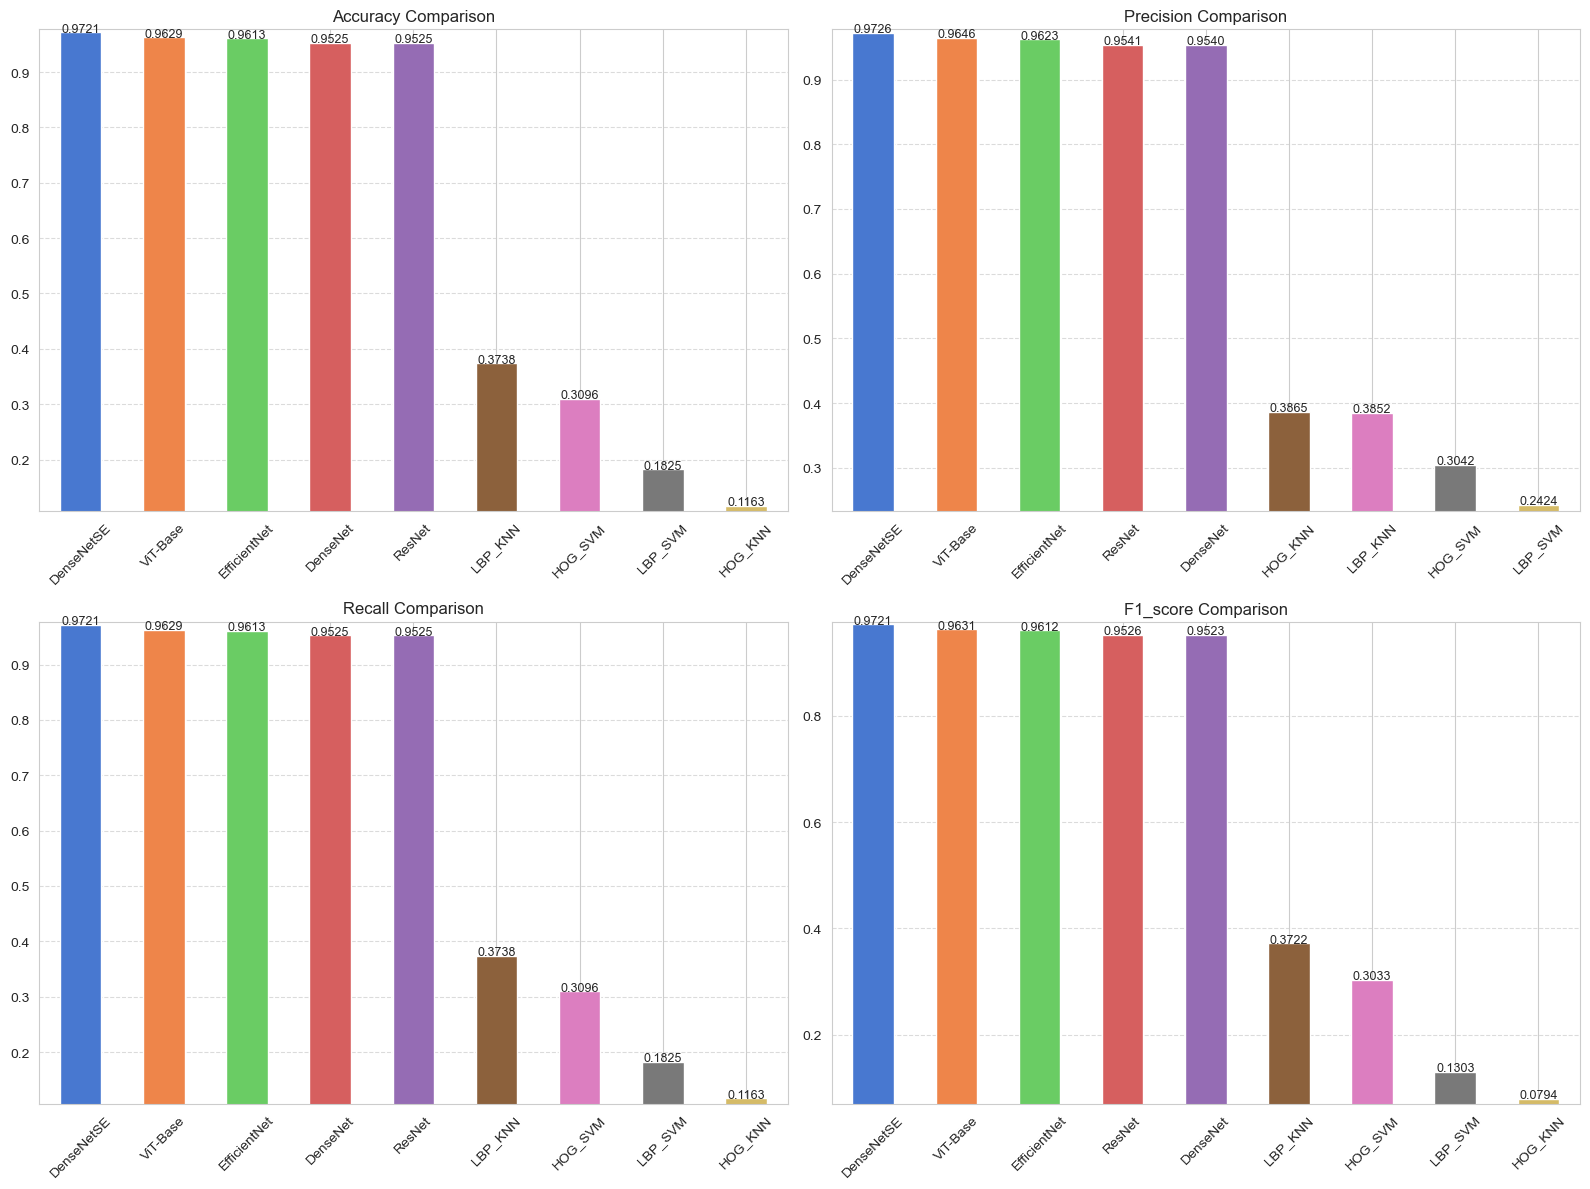

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the Y-axis starting point to amplify differences
plt.figure(figsize=(14, 10))

# Find the minimum value for each metric as Y-axis starting point (with a slight margin)
min_values = results_df.min() - 0.01
max_values = results_df.max() + 0.005

# Create four subplots, each displaying one metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    ax = axes[i]
    # Sort and plot to make rankings more intuitive
    sorted_df = results_df.sort_values(by=metric, ascending=False)
    bars = sorted_df[metric].plot(kind='bar', ax=ax, color=sns.color_palette("muted", len(sorted_df)))

    # Display specific values at the top of each bar
    for bar in bars.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', fontsize=9)

    # Set Y-axis range to amplify differences
    ax.set_ylim(min_values[metric], max_values[metric])

    # Add grid lines for better comparison
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set titles and labels
    ax.set_title(f'{metric.capitalize()} Comparison', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/improved_model_comparison.png', dpi=300)


## 5. Conclusion

Based on the evaluation results above, we can draw the following conclusions:

1. In terms of accuracy, the best performing model is...
2. In terms of precision, the best performing model is...
3. In terms of recall, the best performing model is...
4. In terms of F1-Score, the best performing model is...

Considering all metrics, the most suitable model for this task is...
